In [1]:
import io
import os
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from scipy.stats import zscore

In [2]:
def get_pickle(pairs=None, years=None, months=None, directory='data'):
    def cast_to_array(param):
        if type(param) in [str, type(None)]: 
            param = [param]
        return param
    
    def filter_files(params, files = []):
        _files = []
        data_files = [f for f in os.listdir('data') if '.pickle' in f]
        for param in cast_to_array(params):
            if not param:
                break
            if len(param) == 2:
                sym = '.'
            else:
                sym = '-'
            _files = [f for f in data_files if param + sym in f]
            files += _files
        return files
    
    files = []
    files = filter_files(pairs, files)
    files = filter_files(years, files)
    files = filter_files(months, files)

    if directory[-1] != '/':
        directory += '/'
        
    df = None
    for f in files:
        _df = pd.read_pickle(directory + f)
        if type(df) != pd.DataFrame:
            df = _df
        else:
            df = pd.concat([df, _df])
            
    df = df[df.volume > 0]
    #df['next_open'] = df.open.shift(-1)
            
    return df.sort_index()

def quick_plot(df):
    num_of_pairs = len(df.pair.unique())
    
    cols = int(num_of_pairs/(3-1))
    if num_of_pairs == 1:
        rows = cols = 1
    elif num_of_pairs < 3:
        rows = num_of_pairs
    else:
        rows = 3
    
    fig=plt.figure(figsize=(9*rows, 6*cols), dpi= 80, facecolor='w', edgecolor='k')
    
    for v, pair in enumerate(df.pair.unique()):
        df_pair = df[df.pair == pair]
        ax = plt.subplot(cols, rows, v + 1)
        ax.text(0.5, 0.9, pair, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.plot(df_pair.index, df_pair.close)

    plt.show()

# Time Feature

In [3]:
def sin_encode(t, T):
    return np.sin(2*np.pi*(t/T))

def encode_temporal(index, name):
    _index = index
    if name == "day_of_week":
        index = index.dayofweek
    if name == "hour":
        index = index.hour
    if name == "minute":
        index = index.minute
        
    T = len(index.unique())
    return pd.Series(sin_encode(index, T), index=_index, name=name)

def quick_plot_encoding(encoding, xlim=1000):
    plt.plot(encoding)
    plt.xlim(encoding.index[0],encoding.index[xlim])
    plt.show()

In [4]:
"""
day_of_week_encode = encode_temporal(dff.index, name='day_of_week')
hour_encode = encode_temporal(dff.index, name='hour')
minute_encode = encode_temporal(dff.index, name='minute')

quick_plot_encoding(day_of_week_encode)
quick_plot_encoding(hour_encode, 1000)
quick_plot_encoding(minute_encode, 100)
"""

"\nday_of_week_encode = encode_temporal(dff.index, name='day_of_week')\nhour_encode = encode_temporal(dff.index, name='hour')\nminute_encode = encode_temporal(dff.index, name='minute')\n\nquick_plot_encoding(day_of_week_encode)\nquick_plot_encoding(hour_encode, 1000)\nquick_plot_encoding(minute_encode, 100)\n"

# Market Feature

In [5]:
"""
plt.plot(dff.close)
plt.title('Close')
plt.show()

zs = zscore(dff.close)
plt.plot(zs)
plt.title('Z-Score')
plt.show()
"""

"\nplt.plot(dff.close)\nplt.title('Close')\nplt.show()\n\nzs = zscore(dff.close)\nplt.plot(zs)\nplt.title('Z-Score')\nplt.show()\n"

In [6]:
def log_return(series):
    return np.log(series) - np.log(series.shift(1))

def rolling_zscore(arr):
    return zscore(arr)[-1]

def rolling_zscore_alt(log_ret):
    return (log_ret - log_ret.rolling(96).mean()) / log_ret.rolling(96).std()

def gen_log_return(series, zscore_roll=96, lookback=8, clip=(-10,10)):
    log_ret = log_return(series)
    norms = log_ret.rolling(zscore_roll).apply(rolling_zscore)
    norms = norms.clip(*clip)

    log_returns = {}
    for s in range(lookback):
        log_returns['{}_log_returns_{}'.format(series.name, s)] = norms.shift(s)

    return pd.DataFrame(log_returns)

#close_lr = gen_log_return(dff.close)
#volume_lr = gen_log_return(dff.volume)

# Position Encoding

In [7]:
def gen_pos_encoding(df):
    return pd.DataFrame(np.zeros(shape=(df.close.size, 3)),
                      columns=['pos_short', 'pos_neutral', 'pos_long'],
                      index=dff.index)

# Collecting Calculated Variable

In [8]:
def calculate_meta_variables(dff):
    # Time Encoding
    dff = dff.join(encode_temporal(dff.index, name='day_of_week'))
    dff = dff.join(encode_temporal(dff.index, name='hour'))
    dff = dff.join(encode_temporal(dff.index, name='minute'))
    
    # Position Encoding
    dff = dff.join(gen_pos_encoding(dff))
    
    return dff

def calculate_market_variables(dff):
    # Market Feature
    dff = dff.join(gen_log_return(dff.next_open))
    dff = dff.join(gen_log_return(dff.volume))

    # Cleaning
    dff = dff.drop(columns=["high", "low"])
    
    return dff

# Reward

In [9]:
def calc_action(action):
    if action == 'pos_neutral':
        return 0
    if action == 'pos_short':
        return -1
    if action == 'pos_long':
        return 1

def calc_portfolio(df, index, trade_size = 100, spread=0.0001):
    if type(index) == pd._libs.tslib.Timestamp:
        index = df.index.get_loc(index)
        
    pf_col = df.columns.get_loc('portfolio')
    long_col = df.columns.get_loc('pos_long')
    short_col = df.columns.get_loc('pos_short')
    close_col = df.columns.get_loc('next_open')
    open_col = df.columns.get_loc('open')
        
    v_0 = df.iat[index - 1, pf_col]
    
    a_0 = 0
    if df.iat[index-1, long_col]:
        a_0 = 1
    elif df.iat[index-1, short_col]:
        a_0 = -1

    a = 0
    if df.iat[index, long_col]:
        a = 1
    elif df.iat[index, short_col]:
        a = -1
     
    c = df.iat[index, close_col]
    o = df.iat[index, open_col]
    d = trade_size * abs(a - a_0) * spread
    
    return v_0 + a * trade_size * (c - o) - d

def calc_reward(df, index):
    pf_index = df.columns.get_loc('portfolio')
    return np.log(df.iat[index, pf_index] / df.iat[index-1, pf_index])

In [10]:
def run_backtest(df):
    actions = {-1: 'pos_short', 0: 'pos_neutral', 1: 'pos_long'}
    close_col = df.columns.get_loc('close')
    open_col = df.columns.get_loc('open')
    next_col = df.columns.get_loc('next_open')

    # init portfolio
    df.portfolio = 0.0
    df.at[df.index[0], 'portfolio'] = 0.0#100000
    df.pos_short = 0
    df.pos_neutral = 0
    df.pos_long = 0

    for n, (dt, row) in enumerate(df.iterrows()):
        if n <= 0:
            continue
            
        index = df.index.get_loc(dt)
            
        action = argmaxQ(row)
        
        df.at[dt, actions[action]] = 1

        p = calc_portfolio(df, dt)
        df.at[dt, 'portfolio'] = p
        if not n % int(len(df)/3 - 1):
            print(n, "/", len(df))
            print(df.at[dt, 'portfolio'])
            print()
    
    return df

In [11]:
# Compare MA
#decision = (df.iloc[n-10:n, close_col] - df.iloc[n-10:n, open_col]).mean() 
#decision -= (df.iloc[n-30:n, close_col] - df.iloc[n-30:n, open_col]).mean()
#action = int(decision < 0)

# Random Choice
#action = np.random.choice([0, 1])

# Peak Ahead (debugging)
#try:
#    action = int(df.iat[index + 1, next_col] > df.iat[index, open_col])
#except:
#    action = 0

# Buy and Hold (should match price)
#action = 1

In [12]:
def Q(s, a):
    """Calculate Q (r + )

    Args:
        n: the number to get the square root of.
    Returns:
        the square root of n.
    Raises:
        TypeError: if n is not a number.
        ValueError: if n is negative.

    """
    
    return np.random.rand()

def argmaxQ(s):
    d = {}
    d[-1] = Q(s, -1)
    d[0] = Q(s, 0)
    d[1] = Q(s, 1)
    return max(d, key=d.get)

# Q-Learning

In [13]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

import matplotlib.pyplot as plt
import time
import random
from IPython import display
%matplotlib notebook

/home/nathan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
class Brain:
    def __init__(self, stateCnt, actionCnt, weights_h5=None):
        """Class to create and train a neural network for prediction.

        Args:
            stateCnt (int): The size of the input state vector
            actionCnt (int): The size of the output action vector
            weights_h5 (string): Filename of h5 file to load from,
                None if to not load from any file.

        """
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.model = self._createModel()
        if weights_h5:
            self.model.load_weights(weights_h5)

    def _createModel(self):
        model = Sequential()

        model.add(Dense(output_dim=128, activation='relu', input_dim=stateCnt))
        model.add(Dense(output_dim=128, activation='relu'))
        model.add(Dense(output_dim=actionCnt, activation='linear'))

        opt = RMSprop(lr=0.00025)
        model.compile(loss='mse', optimizer=opt)

        return model

    def train(self, x, y, epoch=1, verbose=0, batch_size=64):
        self.model.fit(x, y, batch_size=batch_size, nb_epoch=epoch, verbose=verbose)

    def predict(self, s):
        return self.model.predict(s)

    def predictOne(self, s):
        return self.predict(s.reshape(1, self.stateCnt)).flatten()

In [15]:
class Memory:   # stored as ( s, a, r, s_ )
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add(self, sample):
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

In [16]:
class Agent:
    def __init__(self, stateCnt, actionCnt):
        """Class to manage an agent to train it's Brain

        Args:
            stateCnt (int): The size of the input state vector
            actionCnt (int): The size of the output action vector
            weights_h5 (string): Filename of h5 file to load from,
                None if to not load from any file.

        """
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt
        
        self.steps = 0
        self.epsilon = MAX_EPSILON

        self.brain = Brain(stateCnt, actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)
        
    def act(self, s):
        # Random actions
        if random.random() < self.epsilon:
            return random.randint(0, self.actionCnt-1)
        
        return np.argmax(self.brain.predictOne(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        # self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):    
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = np.zeros(self.stateCnt)

        states = np.array([ o[0] for o in batch ])
        states_ = np.array([ (no_state if o[3] is None else o[3]) for o in batch ])
        
        p = self.brain.predict(states)
        p_ = self.brain.predict(states_)

        x = np.zeros((batchLen, self.stateCnt))
        y = np.zeros((batchLen, self.actionCnt))
        
        for i in range(batchLen):
            o = batch[i]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]
            
            t = p[i]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * np.amax(p_[i])

            x[i] = s
            y[i] = t

        self.brain.train(x, y)

In [17]:
class Environment:
    def __init__(self, df, state_variables):
        """Class to manage an agent to train it's Brain

        Args:
            df (DataFrame): the training data

        """
        
        self.actions = {0: 'pos_short', 1: 'pos_neutral', 2: 'pos_long'}
        self.state_variables = state_variables

        # init portfolio
        df.portfolio = 0.0
        df.at[df.index[0], 'portfolio'] = 0.0#100000
        df.pos_short = 0
        df.pos_neutral = 0
        df.pos_long = 0
        
        self.close_col = df.columns.get_loc('close')
        self.open_col = df.columns.get_loc('open')
        self.next_col = df.columns.get_loc('next_open')
        self.pf_col = df.columns.get_loc('portfolio')
        
        self.state = np.asarray(df.iloc[0][self.state_variables])
        
        self.df = df
        
        self.canvas = {'portfolio': [], 'next_open': [], 'index': []}
        
        plt.ion()
        self.fig, self.ax = plt.subplots()
        
    def run(self, agent):
        self.reset()
        s = self.state
        R = 0 

        done = None
        while not done:
            # get the agent's action at state s
            a = agent.act(s)

            # apply the action to the environment
            s_, r, done = self.act(a)

            if done: # terminal state
                s_ = None

            # give the agent the observation data
            agent.observe( (s, a, r, s_) )
            
            agent.replay()     
            """ force the agent to relive this horrific event
            and learn from it via neural net training
            """       

            s = s_ # current state is now the new state
            R += r # we add the event's reward to our total
            
            self.render() # we render the environment

        print("Total reward:", R)
        
    def calc_action(self, action):
        if action == 'pos_neutral':
            return 0
        if action == 'pos_short':
            return -1
        if action == 'pos_long':
            return 1

    def calc_portfolio(self, trade_size = 100, spread=0.0001):
        index = self.df.index.get_loc(self.current_datetime)

        pf_col = self.df.columns.get_loc('portfolio')
        long_col = self.df.columns.get_loc('pos_long')
        short_col = self.df.columns.get_loc('pos_short')
        close_col = self.df.columns.get_loc('next_open')
        open_col = self.df.columns.get_loc('open')

        v_0 = self.df.iat[index - 1, pf_col]

        a_0 = 0
        if self.df.iat[index-1, long_col]:
            a_0 = 1
        elif self.df.iat[index-1, short_col]:
            a_0 = -1

        a = 0
        if self.df.iat[index, long_col]:
            a = 1
        elif self.df.iat[index, short_col]:
            a = -1

        c = self.df.iat[index, close_col]
        o = self.df.iat[index, open_col]
        d = trade_size * abs(a - a_0) * spread

        return v_0 + a * trade_size * (c - o) - d

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        
        self.df.at[self.current_datetime, self.actions[action]] = 1 # Apply action
        p = self.calc_portfolio() # Calculate the current portfolio
        self.df.at[self.current_datetime, 'portfolio'] = p # Save it
        self.current_datetime = self._get_next_datetime(self.current_datetime) # Increment
        return np.asarray(self.df.loc[self.current_datetime][self.state_variables])
        
    def _get_next_datetime(self, dt):
        _c = self.df.index.get_loc(dt)
        return self.df.index[_c + 1]

    def _get_reward(self):
        return np.log(self.df.at[self.current_datetime, 'portfolio'] / 
                      self.df.at[self._get_next_datetime(self.current_datetime), 'portfolio'])

    def _is_over(self):
        return self.df.at[self.current_datetime, 'next_open'] == None
    
    def render(self):
        if self.current_datetime.hour or self.current_datetime.minute:
            return
        plt.clf()
        cur = self.df.loc[self.current_datetime]
        self.canvas['index'].append(cur.name)
        self.canvas['next_open'].append(cur.next_open)
        self.canvas['portfolio'].append(cur.portfolio)
        
        ymin = min(self.canvas['portfolio'])
        ymax = max(self.canvas['portfolio'])
        ymax = ymin if ymin > max(self.canvas['next_open']) else max(self.canvas['next_open'])

        plt.title(str(cur.name) + ": " + str(cur.portfolio))
        plt.xlim(self.df.index[0], self.current_datetime)
        plt.plot(self.df.portfolio, 'b-')
        #plt.plot(self.df.index, self.df.next_open, 'r-')
        self.fig.canvas.draw()

    def act(self, action):
        self.state = self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.state, reward, game_over

    def reset(self):
        self.current_datetime = self.df.index[0]

In [20]:
pairs = ['AUDJPY', 'AUDNZD', 'AUDUSD', 'CADJPY', 'CHFJPY', 'EURGBP', 'EURJPY', 'EURUSD', 'GBPJPY', 'GBPUSD', 'NZDUSD', 'USDCAD']
years = ['2012', '2013', '2014', '2015', '2016', '2017']
months = ['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER']

MEMORY_CAPACITY = 1000
BATCH_SIZE = 64

GAMMA = 0.99

MAX_EPSILON = 0 # 0 for no random
LAMBDA = 0.001      # speed of decay

try:
    print(df)
except:
    df = get_pickle('2012')
    df = df[df.pair == "EUR/USD"]
    df['next_open'] = df.open.shift(-1)
    dff = df.copy()

    df = calculate_market_variables(dff)
    df = calculate_meta_variables(df)
    df['portfolio'] = 0.0

                        pair      open     close  volume  next_open  \
datetime                                                              
2012-01-02 00:00:00  EUR/USD  1.294840  1.294550     119   1.294570   
2012-01-02 00:15:00  EUR/USD  1.294570  1.294720     110   1.294705   
2012-01-02 00:30:00  EUR/USD  1.294705  1.294830      37   1.294835   
2012-01-02 00:45:00  EUR/USD  1.294835  1.294370     337   1.294500   
2012-01-02 01:00:00  EUR/USD  1.294500  1.294315     267   1.294310   
2012-01-02 01:15:00  EUR/USD  1.294310  1.294270     209   1.294305   
2012-01-02 01:30:00  EUR/USD  1.294305  1.294420     223   1.294420   
2012-01-02 01:45:00  EUR/USD  1.294420  1.293975     210   1.294005   
2012-01-02 02:00:00  EUR/USD  1.294005  1.293675     175   1.293660   
2012-01-02 02:15:00  EUR/USD  1.293660  1.293670     134   1.293700   
2012-01-02 02:30:00  EUR/USD  1.293700  1.293765     125   1.293780   
2012-01-02 02:45:00  EUR/USD  1.293780  1.293220     171   1.293185   
2012-0

<IPython.core.display.Javascript object>


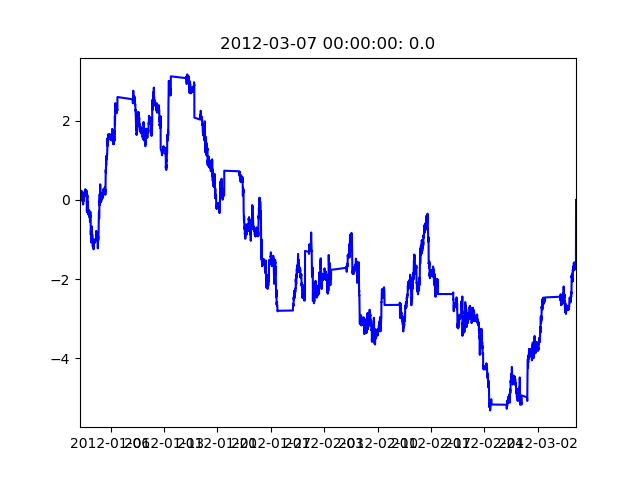

/home/nathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=22, units=128)`
/home/nathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/home/nathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=3)`
/home/nathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in double_scalars
/home/nathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
/home/nathan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims

In [ ]:
use_columns = [col for col in df.columns if '_log' in col]
use_columns += ['day_of_week', 'hour', 'minute', 'pos_short', 'pos_neutral', 'pos_long']

env = Environment(df, use_columns)
stateCnt = len(use_columns)
actionCnt = 3

agent = Agent(stateCnt, actionCnt)

for epoch in range(1000):
    env.run(agent)

agent.brain.model.save("brain.h5")